In [32]:
import matplotlib.pyplot as plt
import scienceplots
import optuna
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_pinball_loss

##
from sklearn.model_selection import train_test_split

plt.style.use(["science", "notebook", "muted"])
plt.rcParams["text.usetex"] = False


def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
y = expected_y + noise


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [33]:
# mask = (X_train[:, 0] > 4) & (X_train[:, 0] < 6)
# X_train = X_train[~mask]
# y_train = y_train[~mask]

# mask = (X_test[:, 0] > 4) & (X_test[:, 0] < 6)
# X_test = X_test[~mask]
# y_test = y_test[~mask]

# mask = (X_train[:, 0] > 7) & (X_train[:, 0] < 9)
# X_train = X_train[~mask]
# y_train = y_train[~mask]

# mask = (X_test[:, 0] > 7) & (X_test[:, 0] < 9)
# X_test = X_test[~mask]
# y_test = y_test[~mask]


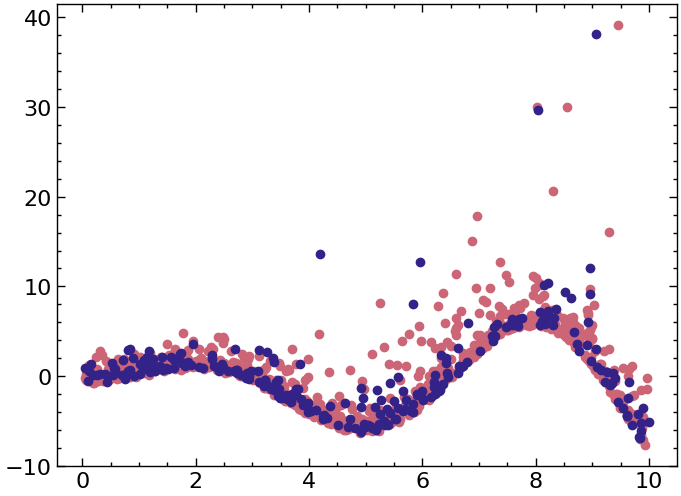

In [34]:
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

How to tune lightgbm

In [35]:
import lightgbm as lgb
import numpy as np
import sklearn.model_selection

import optuna

# 1. Define an objective function to be maximized.
def objective(trial, X, y, alpha, random_state, nfold=5, verbose=-1):
    train_data = lgb.Dataset(X, label=y)
    
    params = {
        "objective": "quantile",
        "alpha": alpha,
        "metric": "quantile",
        "num_boost_round": trial.suggest_int("num_boost_round", 100, 400),
        # "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 31, 3100),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "verbose": verbose,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "seed": random_state,
    }

    cv_results = lgb.cv(
        params=params,
        train_set=train_data,
        nfold=nfold,
        stratified=False, # needed for regression?
        # shuffle=False,
    )

    score = cv_results['valid quantile-mean'][-1] # is this correct?

    return score

In [36]:
def optimise_quantile_regressor(X, y, alpha, n_trials, random_state=42, nfold=5, verbose=-1):
    # Create a study object
    study = optuna.create_study(direction="minimize")

    # Run the optimization process
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(
        lambda trial: objective(
            trial, X, y, alpha, random_state, nfold, verbose
        ),
        n_trials=n_trials,
        show_progress_bar=True,
        # n_jobs=4,
    )

    # Print the best hyperparameters and score
    print("Best hyperparameters:", study.best_params)
    print("Best score:", study.best_value)

    train_data = lgb.Dataset(X, label=y)

    params = study.best_params.copy()
    params.update({
        "objective": "quantile",
        "alpha": alpha,
        "metric": "quantile",
        "seed":random_state,
        "verbose":verbose,
    })
    
    # Train the model
    model = lgb.train(
        params=params,
        train_set=train_data,
    )

    return model

In [37]:
model = optimise_quantile_regressor(X_train, y_train, 0.5, 10, random_state=42, nfold=5, verbose=-1)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/lmfit/lib/python3.10/site-packages/lightgbm/engine.py:738: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Best hyperparameters: {'num_boost_round': 206, 'num_leaves': 2636, 'min_data_in_leaf': 40}
Best score: 0.6863125737322197


/opt/homebrew/Caskroom/miniforge/base/envs/lmfit/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [38]:
model.best_iteration

0

In [39]:
model.num_trees()

206

In [40]:
model.params

{'num_leaves': 2636,
 'min_data_in_leaf': 40,
 'objective': 'quantile',
 'alpha': 0.5,
 'metric': 'quantile',
 'seed': 42,
 'verbose': -1,
 'num_iterations': 206}

In [41]:
%%time
models={}
alphas=[0.05, 0.5, 0.95]
for alpha in alphas:
    print(alpha)
    models[alpha] = optimise_quantile_regressor(X_train, y_train, alpha, 20, random_state=42, nfold=5, verbose=-1)

0.05


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters: {'num_boost_round': 124, 'num_leaves': 1596, 'min_data_in_leaf': 31}
Best score: 0.10843631686864685
0.5


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters: {'num_boost_round': 136, 'num_leaves': 2498, 'min_data_in_leaf': 17}
Best score: 0.6729053692754114
0.95


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters: {'num_boost_round': 124, 'num_leaves': 2694, 'min_data_in_leaf': 100}
Best score: 0.40991199567809133
CPU times: user 57.6 s, sys: 1min 39s, total: 2min 36s
Wall time: 2min 8s


In [42]:
xx = np.linspace(0, 10, 100)[:,np.newaxis]

In [43]:
yhats={}
for alpha in alphas:
    yhats[alpha] = models[alpha].predict(xx)

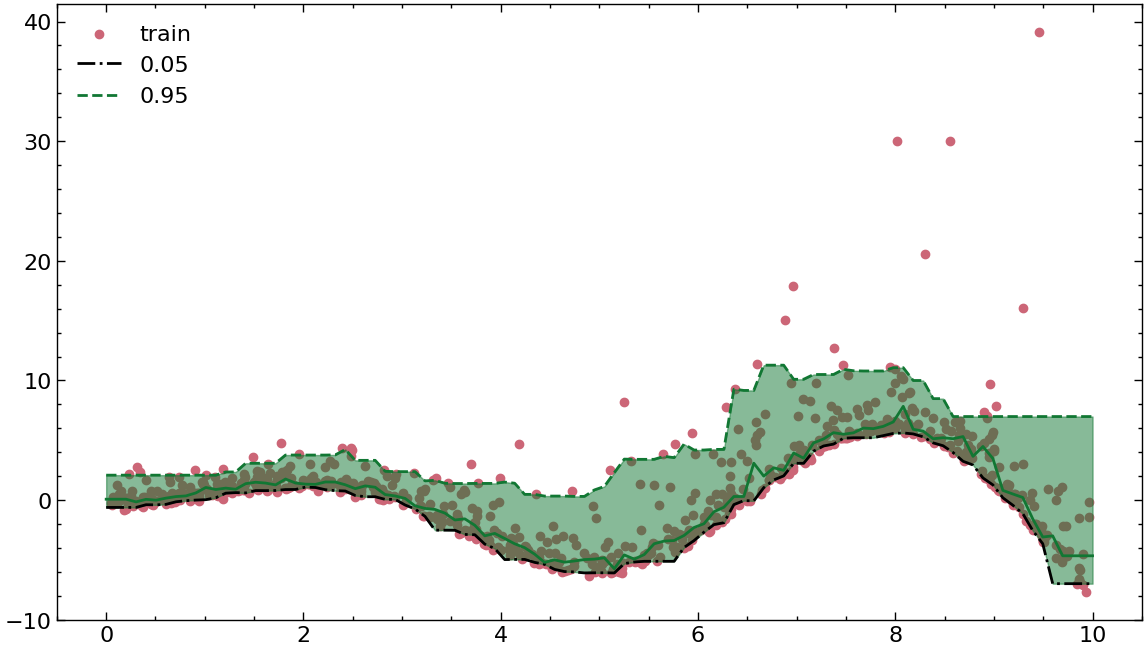

In [44]:
plt.figure(figsize=(14,8))
plt.scatter(X_train, y_train, label="train")
plt.plot(xx, yhats[0.05], c="k", ls="-.", label='0.05')
plt.plot(xx, yhats[0.5], c="C3")
plt.plot(xx, yhats[0.95], c="C3", ls="--", label="0.95")
plt.fill_between(xx[:, 0], yhats[0.05], yhats[0.95], color="C3", alpha=0.5)
plt.legend()

In [45]:
models[0.5].trees_to_dataframe()

tree_index  node_depth node_index left_child right_child parent_index  \
0              0           1       0-S0       0-S2        0-S1         None   
1              0           2       0-S2       0-S3        0-S6         0-S0   
2              0           3       0-S3      0-S14        0-S4         0-S2   
3              0           4      0-S14       0-L0       0-S16         0-S3   
4              0           5       0-L0       None        None        0-S14   
...          ...         ...        ...        ...         ...          ...   
8473         135           3    135-S13    135-S14     135-L14       135-S1   
8474         135           4    135-S14     135-L2     135-L15      135-S13   
8475         135           5     135-L2       None        None      135-S14   
8476         135           5    135-L15       None        None      135-S14   
8477         135           4    135-L14       None        None      135-S13   

     split_feature  split_gain  threshold decision_type missing_direction  \
0         Column_0   30.887899   6.497984            <=              left   
1         Column_0   26.840000   2.731813            <=              left   
2         Column_0   24.012699   0.942125            <=              left   
3         Column_0    0.146617   0.258931            <=              left   
4             None         NaN        NaN          None              None   
...            ...         ...        ...           ...               ...   
8473      Column_0    0.045370   9.523827            <=              left   
8474      Column_0    0.057143   9.309080            <=              left   
8475          None         NaN        NaN          None              None   
8476          None         NaN        NaN          None              None   
8477          None         NaN        NaN          None              None   

     missing_type     value  weight  count  
0            None  0.758996       0    750  
1            None  0.744170     489    489  
2            None  0.770184     219    219  
3            None  0.725663      78     78  
4            None  0.690858      21     21  
...           ...       ...     ...    ...  
8473         None -0.001389      72     72  
8474         None -0.003333      45     45  
8475         None -0.000043      24     24  
8476         None -0.005129      21     21  
8477         None  0.009825      27     27  

[8478 rows x 15 columns]

In [46]:
models[0.05].trees_to_dataframe()

tree_index  node_depth node_index left_child right_child parent_index  \
0              0           1       0-S0       0-S4        0-S1         None   
1              0           2       0-S4       0-L0        0-L5         0-S0   
2              0           3       0-L0       None        None         0-S4   
3              0           3       0-L5       None        None         0-S4   
4              0           2       0-S1       0-L1        0-S2         0-S0   
...          ...         ...        ...        ...         ...          ...   
3201         123           2     123-S2    123-S16      123-L3       123-S0   
3202         123           3    123-S16     123-L1     123-L17       123-S2   
3203         123           4     123-L1       None        None      123-S16   
3204         123           4    123-L17       None        None      123-S16   
3205         123           3     123-L3       None        None       123-S2   

     split_feature    split_gain  threshold decision_type missing_direction  \
0         Column_0  1.537500e+00   4.354769            <=              left   
1         Column_0  1.110220e-16   3.560347            <=              left   
2             None           NaN        NaN          None              None   
3             None           NaN        NaN          None              None   
4         Column_0  1.100370e+01   5.276704            <=              left   
...            ...           ...        ...           ...               ...   
3201      Column_0  7.659810e-02   9.288473            <=              left   
3202      Column_0  3.885000e-04   8.942224            <=              left   
3203          None           NaN        NaN          None              None   
3204          None           NaN        NaN          None              None   
3205          None           NaN        NaN          None              None   

     missing_type     value  weight  count  
0            None -5.251980       0    750  
1            None -5.246980     333    333  
2            None -4.804543     273    273  
3            None -5.188700      60     60  
4            None -5.256090     417    417  
...           ...       ...     ...    ...  
3201         None  0.000122     123    123  
3202         None  0.002222      72     72  
3203         None  0.000094      39     39  
3204         None  0.000267      33     33  
3205         None -0.000005      51     51  

[3206 rows x 15 columns]

In [47]:
models[0.95].trees_to_dataframe()

tree_index  node_depth node_index left_child right_child parent_index  \
0              0           1       0-S0       0-S2        0-S1         None   
1              0           2       0-S2       0-L0        0-L3         0-S0   
2              0           3       0-L0       None        None         0-S2   
3              0           3       0-L3       None        None         0-S2   
4              0           2       0-S1       0-L1        0-L2         0-S0   
...          ...         ...        ...        ...         ...          ...   
1183         123           3     123-S2     123-L2      123-S3       123-S1   
1184         123           4     123-L2       None        None       123-S2   
1185         123           4     123-S3     123-L3      123-L4       123-S2   
1186         123           5     123-L3       None        None       123-S3   
1187         123           5     123-L4       None        None       123-S3   

     split_feature  split_gain  threshold decision_type missing_direction  \
0         Column_0    2.931410   6.267090            <=              left   
1         Column_0    0.007667   4.910354            <=              left   
2             None         NaN        NaN          None              None   
3             None         NaN        NaN          None              None   
4         Column_0    1.591360   8.351164            <=              left   
...            ...         ...        ...           ...               ...   
1183      Column_0    0.021447   6.588088            <=              left   
1184          None         NaN        NaN          None              None   
1185      Column_0    0.007905   8.555785            <=              left   
1186          None         NaN        NaN          None              None   
1187          None         NaN        NaN          None              None   

     missing_type     value  weight  count  
0            None  7.366540       0    750  
1            None  7.361760     468    468  
2            None  6.884340     366    366  
3            None  7.012912     102    102  
4            None  7.374660     282    282  
...           ...       ...     ...    ...  
1183         None  0.000314     414    414  
1184         None -0.013762     159    159  
1185         None  0.000882     255    255  
1186         None  0.011844     141    141  
1187         None -0.009005     114    114  

[1188 rows x 15 columns]